# Analysing the open-loop fight qualities

### Imports preliminares

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig
from numpy import radians

### Criação do sistema

In [2]:
# Creates vehicle and set values
from pyaat.aircraft import Aircraft
minhaAeronave = Aircraft(mass=45e3, Ixx=0.554e6, Iyy=2.53e6,
                         Izz =3.01e6, Izx=0.106e6, Cbarw =3.666,
                         bw=28.42, Sw=95.0)

# Aerodynamic coeficients
minhaAeronave.coef0 = [0.0252, 0.0, 0.382, 0.0, 0.0622, 0.0]
minhaAeronave.coefALPHA = [0.2010, 0.0, 6.29, 0.0, -3.63, 0.0]
minhaAeronave.coefBETA = [0.0, 0.785, 0.0, -0.121, 0.0, 0.174]
minhaAeronave.coefP = [0.0, -0.0794, 0.0, -0.522, 0.0, -0.0587]
minhaAeronave.coefQ = [0.281, 0.0, 14.6, 0.0, -45.5, 0.0]
minhaAeronave.coefR = [0.0, 0.572, 0.0, 0.254, 0.0, -0.277]

minhaAeronave.CLmax = 2.4
minhaAeronave.qmax = 23052.05 # considering 700km/h at sea level
minhaAeronave.Vinf = 200

minhaAeronave.set_control_surface('Profundor', [0.0126, 0.0, 0.3891, 0.0, -1.5980, 0.0],(radians(-30), radians(30)))
minhaAeronave.set_control_surface('Aileron', [0.0, 0.0094, 0.0, -0.1784, 0.0, 0.0080],(radians(-20), radians(30)))
minhaAeronave.set_control_surface('Leme', [0.0, -0.3030, 0.0, -0.0464, 0.0, -0.1594],(radians(-40), radians(40)))

from pyaat.atmosphere import atmosISA
minhaAtmosfera = atmosISA()

from pyaat.gravity import NewtonGravity
minhaGravidade = NewtonGravity()

from propulsion import JetModel
MotorEsquerdo = JetModel('Motor esquerdo', Fmaxi = 35e3, nrho = 0.775, rhoi = 0.41271,
                         Vi = 200.0, nv = 0)
MotorEsquerdo.position = np.array([0, -5, 1.42])
MotorEsquerdo.attitude = np.array([0., radians(3.), 0.])

MotorDireito = JetModel('Motor direito', Fmaxi = 35e3, nrho = 0.775, rhoi = 0.41271,
                         Vi = 200.0, nv = 0)
MotorDireito.position = np.array([0, 5.0, 1.42])
MotorDireito.attitude = np.array([0., radians(3.), 0.])

minhaPropulsao = [MotorEsquerdo, MotorDireito]

from system import system
meuSistema = system(atmosphere = minhaAtmosfera,
                    propulsion = minhaPropulsao,
                    aircraft = minhaAeronave,
                    gravity = minhaGravidade)

ImportError: cannot import name 'NewtonGravity' from 'pyaat.gravity' (/home/ydor9e/.local/lib/python3.10/site-packages/PyAAT-0.0.dev10-py3.10.egg/pyaat/gravity.py)

### Balanço

In [ ]:
Xe, Ue = meuSistema.trimmer(condition = 'cruize', zo = -10000, u = 224.6)

In [ ]:
Ue

array([ 2.82111577e-02, -7.27175157e-21, -1.10965573e-21,  3.83734507e-01,
        0.00000000e+00,  5.23598776e-02,  3.83734507e-01,  0.00000000e+00,
        5.23598776e-02])

In [ ]:
np.degrees(Ue[0])

1.6163802741298303

### Prints

In [ ]:
from pyaat.tools import printInfo
printInfo(Xe, Ue, frame ='body')

--------------------------------
------------ STATES ------------
------------- BODY -------------
--------------------------------
x
0.0
-------------
y
0.0
-------------
z
-10000.0
-------------
u
224.6
-------------
v
0.0
-------------
w
1.7086049970878057
-------------
phi
0.0
-------------
theta
0.43585915760295174
-------------
psi
0.0
-------------
p
1.0559776651363619e-18
-------------
q
5.8420017605141234e-08
-------------
r
9.992600339962823e-21


In [ ]:
np.set_printoptions(suppress=True)

### Linearização

In [ ]:
A, B = meuSistema.Linearize(Xe, Ue)

In [ ]:
#A = np.around(A, decimals =5)
#B = np.around(B, decimals =5)
from numpy import identity, array
Aprint = np.around(A, decimals = 4)
Bprint = np.around(B, decimals = 4)

In [ ]:
from flightmechanics import modesMatrix

In [ ]:
def bmatrix(a):
    text = r'$\left[\begin{array}{*{'
    text += str(len(a[0]))
    text += r'}c}'
    text += '\n'
    for x in range(len(a)):
        for y in range(len(a[x])):
            text += str(a[x][y])
            text += r' & '
        text = text[:-2]
        text += r'\\'
        text += '\n'
    text += r'\end{array}\right]$'

    print(text)

In [ ]:
#Aprint

In [ ]:
#bmatrix(Bprint)

In [ ]:
from numpy.linalg import eig

In [ ]:
from flightmechanics import longMatrix, shortPeriodMatrix, phugoidMatrix
Al, Bl = longMatrix(A,B)
Asp, Bsp = shortPeriodMatrix(A, B)
Aph, Bph = phugoidMatrix(A, B)

from flightmechanics import lateroMatrix, rollMatrix, dutchRollMatrix, spiralMatrix
Ald, Bld = lateroMatrix(A,B)
Arp, Brp = rollMatrix(A, B)
Adr, Bdr = dutchRollMatrix(A, B)
As, Bs = spiralMatrix(A, B)

In [ ]:
from flightmechanics import longMatrix
Al, Bl = longMatrix(A,B)

In [ ]:
w, v= eig(A)

### Frequências naturais do sistema

In [ ]:
from numpy import sqrt
def fingOmegaZeta(real, img):
    omega = np.sqrt((-real)**2 + img**2)
    zeta = -real/(np.sqrt((-real)**2+img**2))
    
    if (img==0):
        omega = 1/real
        zeta = "Non-oscilatory"
        
    return omega, zeta

In [ ]:
w, v = eig(A)
wl, vl = eig(Al)
wph, vph = eig(Aph)
wsp, vsp = eig(Asp)

In [ ]:
wl

array([-0.91113605+2.23689527j, -0.91113605-2.23689527j,
       -0.00177347+0.06573911j, -0.00177347-0.06573911j,
       -0.00103007+0.j        ])

In [ ]:
w, z = fingOmegaZeta(-0.00177347, 0.06573911)

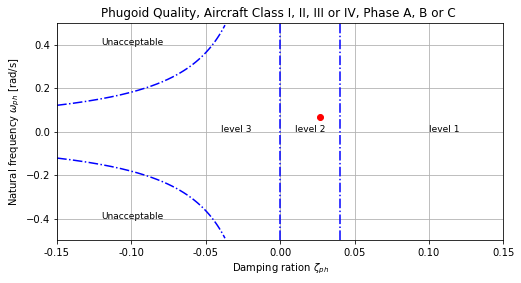

In [ ]:
from flightmechanics import phugoidQuality
phugoidQuality(w, z, aircraft = 'III', phase = 'B')
#plt.savefig('phugoid.png', dpi = 400, bbox_inches='tight')

In [ ]:
w, z = fingOmegaZeta(-0.91113605, 2.23689527)

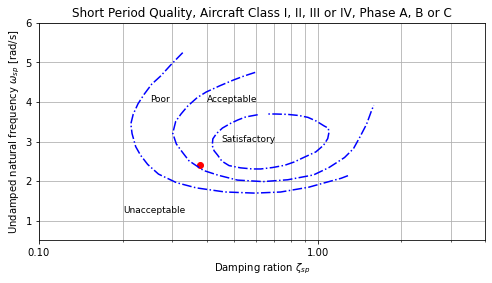

In [ ]:
from flightmechanics import  shortPeriodQuality
shortPeriodQuality(w, z, aircraft = 'III', phase = 'B')
plt.savefig('short_period.png', dpi = 400, bbox_inches='tight')

In [ ]:
wld, vld = eig(Ald)
wrp, vrp = eig(Arp)
wdr, vdr = eig(Adr)
ws, vs = eig(As)

In [ ]:
w

2.415340421257007

In [ ]:
ws

array([0.00534567])

In [ ]:
T, z = fingOmegaZeta(-3.8090, 0)

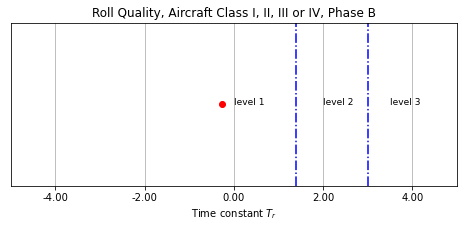

In [ ]:
from flightmechanics import rollQuality
rollQuality(T, aircraft = 'III', phase = 'B')
plt.savefig('roll_quality.png', dpi = 400, bbox_inches='tight')

In [ ]:
w, z = fingOmegaZeta(-0.1218, 1.3339)

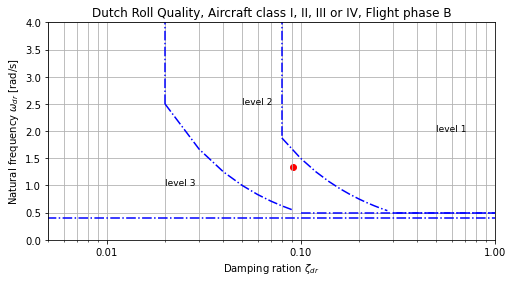

In [ ]:
from flightmechanics import dutchRollQuality
dutchRollQuality(w, z, aircraft = 'III', phase = 'B')
plt.savefig('dutchRoll_quality.png', dpi = 400, bbox_inches='tight')

In [ ]:
T, z = fingOmegaZeta(0.0051, 0)

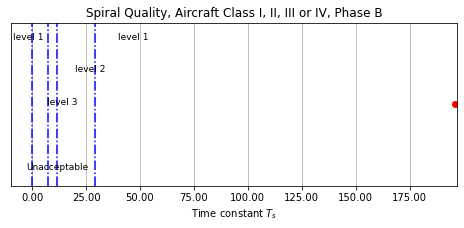

In [ ]:
from flightmechanics import spiralQuality
spiralQuality(T, aircraft = 'III', phase = 'B')
plt.savefig('spiral_Quality.png', dpi = 400, bbox_inches='tight')